In [1]:

import numpy as np
import matplotlib.pyplot as plt

In [2]:
class BernoulliBandit:
    """ 伯努利多臂老虎机，输入K为拉杆个数 """
    def __init__(self, K):
        self.probs = np.random.uniform(size=K)  # 随机生成0-1之间的数，作为每个拉杆的获奖概率
        self.best_idx = np.argmax(self.probs)   # 获奖概率最大的拉杆
        self.best_prob = self.probs[self.best_idx]  # 最大的获奖概率
        self.K = K

    def step(self, k):
        # 当玩家选择k号拉杆后，根据该老虎机k号拉杆获得奖励的概率返回1(获奖)或者0（未获奖）
        if np.random.rand() < self.probs[k]:
            return 1
        else:
            return 0

np.random.seed(1)   # 设定随机种子， 使实验具有可重复性
K = 10
bandit_10_arm = BernoulliBandit(K)
print("随机生成了一个 %d臂伯努利老虎机" % K)
print("获得奖励概率最大的拉杆为%d号，其获奖概率为%.4f" % (bandit_10_arm.best_idx, bandit_10_arm.best_prob))

随机生成了一个 10臂伯努利老虎机
获得奖励概率最大的拉杆为1号，其获奖概率为0.7203


接下来我们以一个Solver基础类来实现上述的多臂老虎机的求解方案。我们需要实现的函数：
1. 根据策略选择动作
2. 根据动作获得奖励
3. 更新奖励估值
4. 更新累计懊悔(cumulative Regret)和计数

run_on_step:包含根据策略选择动作、根据动作获取奖励 和 更新期望奖励估值,**每个继承Solver类的策略实现**
run:更新累计懊悔和计数

In [3]:
class Solver:
    """
    多臂老虎机算法基本框架
    """
    def __init__(self, bandit):
        self.bandit = bandit
        self.counts = np.zeros(self.bandit.K)   # 每个拉杆尝试的次数
        self.regret = 0. # 当前步累计懊悔值
        self.actions = [] # 维护一个列表，记录每一步的动作
        self.regrets = [] # 维护一个列表，记录每一步的累计懊悔

    def update_regret(self, k):
        # 计算累计懊悔并保存，k为本次行动选择的拉杆的编号
        self.regret += self.bandit.best_prob - self.bandit.probs[k]
        self.regrets.append(self.regret)

    def run_one_step(self):
        # 返回当前行动选择哪一个拉杆，由每个具体的策略实现
        raise NotImplementedError

    def run(self, num_steps):
        # 运行num_steps次
        for _ in range(num_steps):
            k = self.run_one_step()
            self.counts[k] += 1
            self.actions.append(k)
            self.update_regret(k)

## 探索和利用(Exploration and exploitation)
在以上算法流程中，还没有一个策略告诉我们应该采取哪个动作，即拉动哪个拉杆，所以接下来我们将来学习如何设计一个策略。例如一个最简单的策略就是一直采取第一个动作，但这就非常取决于运气。如果运气绝佳，可能刚好是能获得最大期望奖励的拉杆，即最优拉杆；但如果运气很糟糕，就有可能是最小的期望奖励。于是在多臂老虎机任务中，一个经典的问题就是探索与利用的平衡问题。策略的设计就需要考虑这个问题。其中**探索(Exploration)**是指尝试更多可能的拉杆，这个拉杆不一定会获取最优奖励，但能够清楚所有拉杆的获奖情况，也即对于一个 10 臂老虎机，我们要去把所有的拉杆都试一下才知道哪个拉杆可能获得最大的奖励。而**利用 (Exploitation)** 是指拉动已知平均奖励中最优的那个拉杆。由于已知的信息仅仅来自于有限次的交互观测，所以当前最优的拉杆不一定是真正全局最优。例如，对于一个 10 臂老虎机，我们只试过其中 3 个拉杆，接下来就一直拉动这 3 个拉杆中平均奖励最大的那个拉杆，但很有可能期望奖励最大的拉杆在剩下 7 个当中；即使我们对 10 个拉杆各自都尝试过了 20 次，发现 5 号拉杆的经验平均奖励是最高的，但仍然存在着微小的概率使得另一个 6 号拉杆的真实期望奖励是比 5 号拉杆更高的。

于是在多臂老虎机问题中，我们需要平衡探索和利用的次数，使得能最大化累积奖励。一个比较大致的思路是在一开始的时候做比较多的探索，在对每个拉杆都有比较准确的估计后，再进行利用。目前存在一些比较经典的算法来解决这个问题，
它们是
- 贪心算法
- UCB 算法
- 汤普森采样算法

### $\epsilon$-Greedy（$\epsilon-贪心算法$）
完全贪心算法，即在每一时刻采取期望奖励估值最大的动作，这就是纯粹的利用，并且**没有探索**。

所以对完全贪心进行一些修改在完全贪心算法的基础上添加了噪声，每次以概率1-$\epsilon$选择以往经验中期望奖励估值最高的那个拉杆，以概率$\epsilon$随机选择一个拉杆，公式如下：
![](https://gitee.com/wubmu/image/raw/master/img/20210817203711.png)
随着时间的不断推进，我们对各个动作的奖励估计得越来越准，此时我们就没太大必要继续花大力气进行探索。所以在$\epsilon$-贪心算法的具体实现中，我们可以令$\epsilon$ 随时间衰减，也即探索的概率将会不断降低。但是请注意，$\epsilon$不会在有限的步数内衰减至0，因为基于有限步数观测的完全贪心算法仍然是一个局部信息的贪心算法，永远距离最优解有一个固定的差距。


我们接下来用代码实现一个$\epsilon$-贪心算法，并用它去解决前文生成的10臂老虎机。我们设置$\epsilon = 0.01$，以及$T=5000$。

In [4]:
class EpsilonGreedy(Solver):
    """EpsilonGreedy,继承Solver"""
    def __init__(self, bandit, epsilon=0.01, init_prob=1.0):
        super(EpsilonGreedy,self).__init__(bandit)
        self.epsilon = epsilon
        self.estimates = np.array([init_prob] * self.bandit.K) #  初始化对所有拉杆的奖励估值

    def run_one_step(self):
        if np.random.random() < self.epsilon:
            k = np.random.randint(0, self.bandit.K) # 随机选择一个拉杆
        else:
            k = np.argmax(self.estimates)   # 选择奖励估值最大的拉杆
        r = self.bandit.step(k) # 本次动作的奖励
        self.estimates[k] += 1. / (self.counts[k] + 1)* ( r - self.estimates[k])
        return k

为了更加直观地展示，我们把每一时间步的累积函数画出来。于是我们定义了以下画图函数，方便之后调用。

In [5]:
def plot_results(solvers, solver_names):
    """生成累积懊悔随时间变化的图像。输入solvers是一个列表，列表中每个元素是一种特定的策略。而solver_names也是一个列表，包含每个策略的名称"""
    for idx, solver in enumerate(solvers):
        time_list = range(len(solver.regrets))
        plt.plot(time_list, solver.regrets, label=solver_names[idx])
        plt.xlabel('Time steps')
    plt.ylabel('Cumulative regrets')
    plt.title('%d-armed bandit' % solvers[0].bandit.K)
    plt.legend()
    plt.show()

epsilon贪心算法的累积懊悔为： 25.526630933945313


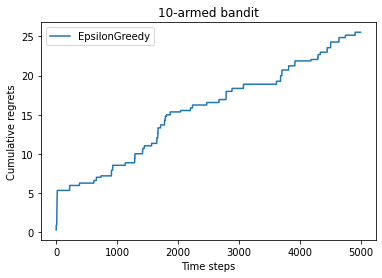

In [6]:
np.random.seed(1)
epsilon_greedy_solver = EpsilonGreedy(bandit_10_arm, epsilon=0.01)
epsilon_greedy_solver.run(5000)
print('epsilon贪心算法的累积懊悔为：', epsilon_greedy_solver.regret)
plot_results([epsilon_greedy_solver], ["EpsilonGreedy"])

通过上面实验我们发现，在经历了开始的一小段时间后，$\epsilon$-贪心算法的累积懊悔几乎是线性增长的。这是$\epsilon=0.01$时的结果，因为一旦做出了随机拉杆的探索，那么带来的懊悔值是固定的。那其他不同的 $\epsilon$ 取值又会带来怎样的变化呢？我们继续使用该10臂老虎机，我们尝试不同的参数: $\{10^{-4}, 0.01, 0.1, 0.25, 0.5\}$，查看相应实验结果

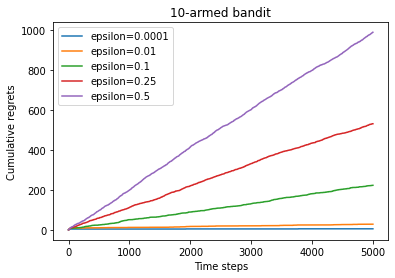

In [7]:
np.random.seed(0)
epsilons = [1e-4, 0.01, 0.1, 0.25, 0.5]
epsilon_greedy_solver_list = [EpsilonGreedy(bandit_10_arm, epsilon=e) for e in epsilons]
epsilon_greedy_solver_names = ["epsilon={}".format(e) for e in  epsilons]
for solver in epsilon_greedy_solver_list:
    solver.run(5000)
plot_results(epsilon_greedy_solver_list, epsilon_greedy_solver_names)

通过实验结果，我们发现基本上无论$\epsilon$取值多少，累积懊悔都是线性增长的。在这个例子中，随着$\epsilon$的增大，累积懊悔增长的速率也会增大。

接下来我们尝试$\epsilon$值随时间衰减的$\epsilon$-贪心策略，采取的具体衰减形式为线性衰减，具体公式为 $\epsilon_t = \frac{1}{t}$。

In [8]:
class DecayingEpsilonGreedy(Solver):
    """epsilon取值随时间衰减的Epsilon贪心算法,继承Solver类"""
    def __init__(self, bandit, init_prob=1.0):
        super(DecayingEpsilonGreedy, self).__init__(bandit)
        self.estimates = np.array([init_prob] * self.bandit.K)
        self.total_count = 0

    def run_one_step(self):
        self.total_count += 1
        if np.random.random() < 1 / self.total_count: # epsilon随时间衰减
            k = np.random.randint(0, self.bandit.K)
        else:
            k = np.argmax(self.estimates)

        r = self.bandit.step(k)
        self.estimates[k] += 1. / (self.counts[k] + 1) * (r - self.estimates[k])

        return k

epsilon衰减的贪心算法的累积懊悔为： 10.114334931260183


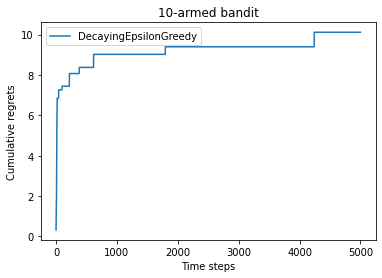

In [9]:
np.random.seed(1)
decaying_epsilon_greedy_solver = DecayingEpsilonGreedy(bandit_10_arm)
decaying_epsilon_greedy_solver.run(5000)
print('epsilon衰减的贪心算法的累积懊悔为：', decaying_epsilon_greedy_solver.regret)
plot_results([decaying_epsilon_greedy_solver], ["DecayingEpsilonGreedy"])

从上图我们看到，随着时间做指数衰减的$\epsilon$-贪心策略能够使得累计懊悔与时间的关系变成次线性 (Sublinear) 的，这明显优于固定$\epsilon$值的$\epsilon$-贪心策略。


### 上置信界算法(Upper Confidence Bound, UCB)
上置信界算法UCB (Upper Confidence Bound) 是一种经典的基于不确定性的策略算法。它的思想用到了一个非常著名的数学原理：霍夫丁不等式 (Hoeffding's Inequality)。在霍夫丁不等式中，令 $X_1,...,X_n$ 为 $n$ 个独立同分布的随机变量，取值范围为 $[0,1]$，其经验期望为 $\bar{x}_n = \frac{1}{n}\sum_{j=1}^{n}X_j$，则有
$$
\begin{align*}
\mathbb{P}\left\{ \mathbb{E}\left[X\right] \geq \bar{x}_t + u \right\} \leq e^{-2nu^2}
\end{align*}
$$

现在我们将霍尔丁不等式运用于多臂赌博机问题中。将$\hat{Q}_t(a)$ 代入 $\bar{x}_t$，并认为不等式中的参数 $u = \hat{U}_t(a)$ 代表不确定性度量。给定一个概率 $p= e^{-2N_t(a)U_t(a)^2}$,根据不等式,$Q_t(a) < \hat{Q}_t(a) + \hat{U}_t(a)$ 至少以概率 $1-p$ 成立。当$p$很小时，$Q_t(a) <\hat{Q}_t(a) + \hat{U}_t(a)$就以很大概率成立，此时$\hat{Q}_t(a) + \hat{U}_t(a)$便是期望奖励的上界。于是，上置信界算法便选取期望奖励上界最大的动作，即$a = \underset{a\in\mathcal{A}}{\text{argmax}} \left[\hat{Q}(a) + \hat{U}(a)\right]$。那其中$\hat{U}_t(a)$具体是什么呢？根据式子$e^{-2N_t(a)U_t(a)^2}$，解之即得 $\hat{U}_t(a) = \sqrt{\frac{-\log p}{2N_t(a)}}$。所以设定一个概率$p$后，就可以计算相应的不确定性度量$\hat{U}_t(a)$了。更直观地说，UCB方法在每次选择拉杆前，先估计每根拉杆的期望奖励的上界，使得每根拉杆的期望奖励只有一个较小的概率 $p$ 超过这个上界。接着选出期望奖励上界最大的拉杆，从而选择最有可能是期望奖励最大的拉杆。


我们下面将用代码实现UCB算法，并且仍然使用上文定义的10臂老虎机来观察实验结果。在具体实现过程中，我们设置$p=\frac{1}{t}$，并且在分母中每个拉杆的次数加上常数1，以免出现除以0的情形，即此时$\hat{U}_t(a) = \sqrt{\frac{\log t}{2(N_t(a)+1)}}$。并且我们设定一个系数$c$来控制不确定性的比重，此时$a = \underset{a\in\mathcal{A}}{\text{argmax}} \left[\hat{Q}(a) + c \cdot \hat{U}(a)\right]$

In [10]:
class UCB(Solver):
    """UCB算法"""
    def __init__(self, bandit, coef, init_prob=1.0):
        super(UCB, self).__init__(bandit)
        self.total_count = 0
        self.estimates = np.array([init_prob] * self.bandit.K)
        self.coef = coef
        
    def run_one_step(self):
        self.total_count += 1
        ucb = self.estimates + self.coef * np.sqrt(np.log(self.total_count) / (2 * (self.counts + 1))) # 计算上置信界
        k = np.argmax(ucb) # 选出上置信界最大的拉杆
        r = self.bandit.step(k)
        self.estimates[k] += 1. / (self.counts[k] + 1) * (r - self.estimates[k])
        return k

In [ ]:
np.random.seed(1)
coef = 0.1 # 控制不确定性比重的系数
UCB_solver = UCB(bandit_10_arm, coef)
UCB_solver.run(5000)
print('上置信界算法的累积懊悔为：', UCB_solver.regret)
plot_results([UCB_solver], ["UCB c=0.1"])

### 汤普森采样算法(Thompson Sampling)


上置信界算法的累积懊悔为： 4.360254345326592


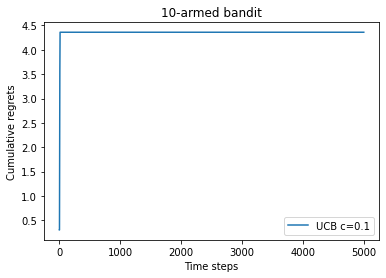

### 汤普森采样算法(Thompson Sampling)
